In [2]:
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.tree import export_graphviz

In [3]:
df_shifts = pd.read_csv('../data/interim/combined_precleaned.csv')
df_shifts.columns.values

array(['Unnamed: 0', 'id', 'created_at', 'shift_id', 'action',
       'worker_id', 'facility_id', 'lead_time', 'dayOfWeek', 'hourOfDay',
       'shift_day', 'id_shift', 'facility_id_shift', 'start_shift',
       'agent_req_shift', 'end_shift', 'deleted_shift',
       'shift_type_shift', 'created_at_shift', 'verified_shift',
       'charge_shift', 'time_shift', 'dayOfWeek_shift', 'hourOfDay_shift',
       'day_shift', 'totalComp_shift', 'short_shift', 'holiday_shift_ind',
       'weather_shift_ind', 'canceled'], dtype=object)

In [4]:
# TODO: some more cleanup in previous notebook (thought I'd done that..):
# both facility_id and facility_id_shift still here
# both dayOfWeek_shift and dayOfWeek still here (dito hour)
# short_shift still here

### Feature selection

In [5]:
# select subset of columns as features: omit those that are merely 'administrative' or redundant
# TODO: consider additional feature derived from end_shift (hourOfDay_shift_end) - together with hourOfDay_shift, may be better indicator for day/eve/night shift than shift_type_shift, similar to time_shift being better than short_shift
numerical_features = ['time_shift', 'charge_shift', 'totalComp_shift']
categorical_features = ['facility_id', 'dayOfWeek_shift', 'hourOfDay_shift', 'agent_req_shift', 'shift_type_shift', 'holiday_shift_ind', 'weather_shift_ind']
label = 'canceled'

df_feat = df_shifts[numerical_features + categorical_features + [label]]
df_feat.head(5)

# DEBUG
df_feat.drop(columns='facility_id', inplace=True, axis=1)

C:\Users\cwitt\AppData\Local\Temp/ipykernel_7304/3155843567.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feat.drop(columns='facility_id', inplace=True, axis=1)


In [6]:
# define label vs. features
y = df_feat.canceled
X = df_feat[df_feat.columns.difference([y.name])]

### Determine the Scaler

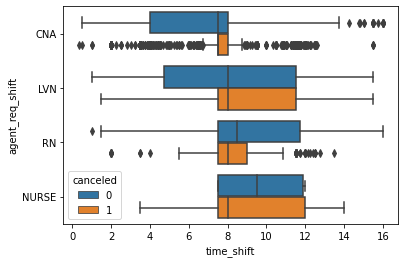

In [7]:
# charge_shift, time_shift, totalComp_shift need to be centered & scaled
sns.boxplot(data=df_feat, x='time_shift', y='agent_req_shift', hue='canceled');

While there are outliers, looking across healthcare worker types none of the very short and very long shift length are inherently implausible. It may be worth investigating whether very short shifts are booked by the same worker adjacent to a longer shift. 

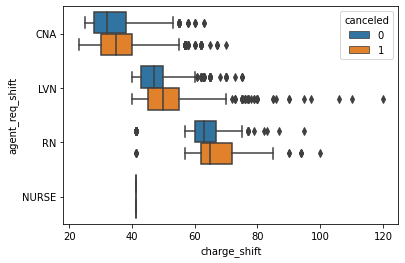

In [8]:
sns.boxplot(data=df_feat, x='charge_shift', y='agent_req_shift', hue='canceled');

Hourly charges for three LVNs are higher than the highest outlier for RNs. Again, this may not be inherently implausible, with potential explanations such as special training or to balance short shift length. Latter may be worth investigating.

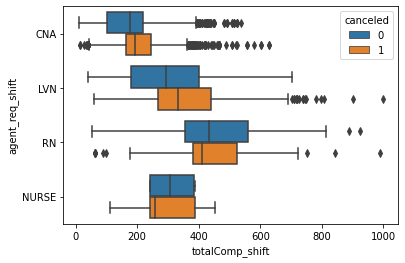

In [9]:
sns.boxplot(data=df_feat, x='totalComp_shift', y='agent_req_shift', hue='canceled');

None of the outliers can be identified as obvious 'mistakes'. However, their presence indicates use of Robust scaling.

### Set up preprocessing: scale and one-hot encode

In [10]:
# define factory method for scaler (note that scaler needs to be derived from training set only, then applied to both train and test data)
def make_scaler():
    return RobustScaler()

In [11]:
# setup a preprocessor to scale numerical features and one-hot encode categorical features(later to be included in pipeline)

# note: facility_id has a large number of categories -> explicitly include so the training set will not miss any
facility = 'facility_id'
# DEBUG facility_categories = df_feat.facility_id.unique()
remain_cat_features = [i for i in categorical_features if i != facility]

# keep hold to encoder than to retrieve it (bug in retrieval code...)
onehot_encoder = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('scale_numerical', make_scaler(), numerical_features),
        # DEBUG ('onehot_facility', OneHotEncoder(categories = facility_categories), [facility]),
        ('onehot_categorical', onehot_encoder, remain_cat_features)
    ],
    remainder='passthrough'
)

### Determine the Test / Train Split

In [12]:
df_feat.canceled.value_counts()

canceled
0    7998
1    5486
Name: count, dtype: int64

Somewhat imbalanced classes, may benefit from stratification (and/or from suffling, since it was sorted according to created_at during munging/EDA).

In [13]:
# define factory method for train/test split for cross validation
def make_cv_strategy():
    return StratifiedShuffleSplit(n_splits=5 , test_size=0.3)

### Perform Grid Search / Cross Validation

Models for comparison: Random Forest, Decision Tree

In [14]:
def make_rf_classifier():
    param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 5, 10]
    }
    classifier = RandomForestClassifier()
    return (classifier, param_grid)

In [15]:
def make_tree_classifier(name='classifier'):
    param_grid = {
    name + '__criterion': ['gini'], # ['gini', 'entropy']
    name + '__max_depth': [i for i in range(2,9)],
    # name + '__min_samples_split': [50, 100, 200, 500],
    name + '__min_samples_leaf': [50, 75, 100, 150, 250, 500],
    # there are just over 100 featuers, given the cardinality of the categorical features (incl. 60 facilities)
    # DEBUG  [30, 45, 60, 75, 90]
    name + '__max_features':  [10, 15, 20, 25, 30, 35]
    }
    classifier = DecisionTreeClassifier()
    return (classifier, param_grid)

Perform Grid Search / Cross Validation

In [16]:
# grid search w. cross validation
model_name = 'classifier'
classifier  = make_tree_classifier(model_name)

pipe = Pipeline([
    ('preprocessor', preprocessor),
    (model_name, classifier[0])
])

gs_cv = GridSearchCV(pipe, classifier[1], cv=make_cv_strategy())
gs_cv.fit(X,y)
print("Best Score:" + str(gs_cv.best_score_))
print("Best Parameters: " + str(gs_cv.best_params_))

Best Score:0.7538803756796836
Best Parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 8, 'classifier__max_features': 30, 'classifier__min_samples_leaf': 50}


Visualize the Decision Tree

In [21]:
# retrieve the feature names generated by the column transformer (input to model)
best_pipeline = gs_cv.best_estimator_
column_transformer = best_pipeline.named_steps['preprocessor']
feature_names = column_transformer.get_feature_names_out()

In [25]:
# generate a tree representtion into file
model = gs_cv.best_estimator_.named_steps.get(model_name)
class_dict = {0:'booked', 1:'canceled'}

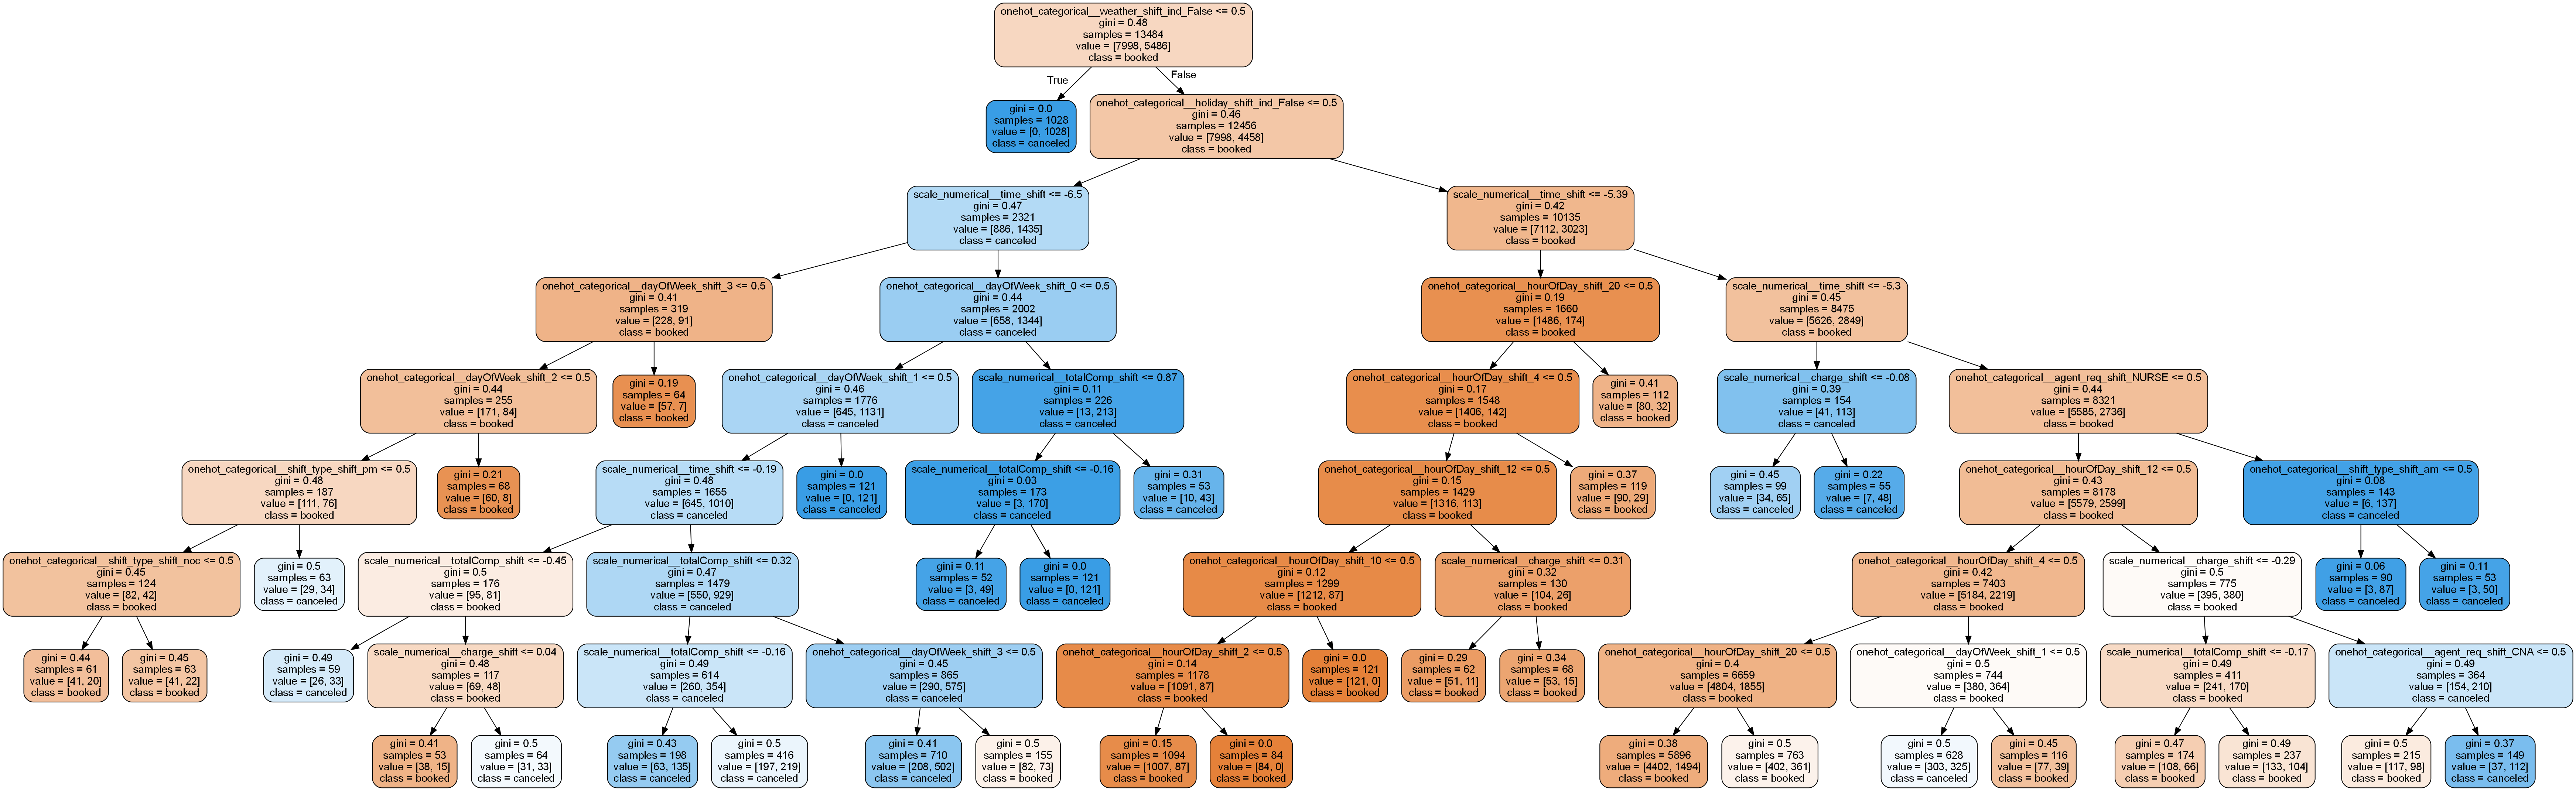

In [26]:
export_graphviz(model, out_file='tree.dot', 
                feature_names = feature_names,
                 # note on order: checked that it's same as unique()
                class_names = [class_dict.get(i) for i in model.classes_],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# convert it to image
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=150'])

# display in notebook
from IPython.display import Image
Image(filename = 'tree.png')

I suspect this points to lack of convergence...

Some things to sanity check:
* double check weather indicator: is time window of canceled shifts consistent with weather date range?

Some things to try: save current state , then re-do with time window of canceled/booked shifts the same
    